<a href="https://colab.research.google.com/github/ee-689-boun/tsdl/blob/main/ar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git
if 'google.colab' in str(get_ipython()):    
    !pip uninstall statsmodels -y
    !pip install statsmodels pmdarima yfinance

In [7]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import yfinance as yf
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import random
import pmdarima as pm

# Data Prep

### Data Load

In [9]:
PATH = "/content/drive/MyDrive/tsdl/Data/"

In [10]:
FNAME = "EUR_USD_Data.csv"

In [11]:
inv_data_raw = pd.read_csv(f'{PATH}{FNAME}', low_memory=False, parse_dates=["Date"])

In [12]:
inv_data_raw.head()

,Date,Price,Open,High,Low,Change %
0,2021-01-29,1.2136,1.2121,1.2156,1.2093,0.12%
1,2021-01-28,1.2121,1.2109,1.2142,1.2079,0.11%
2,2021-01-27,1.2108,1.2160,1.2170,1.2057,-0.43%
3,2021-01-26,1.2160,1.2138,1.2177,1.2107,0.19%
4,2021-01-25,1.2137,1.2168,1.2184,1.2115,-0.25%


### Create Time Series

In [13]:
def find_missing_dates(df):
  all_dates = pd.date_range(start=df.index.min(), 
                            end=df.index.max())
  return [date for date in all_dates.difference(df.index) 
          if not date.dayofweek in [5, 6]]

In [14]:
inv_data =  inv_data_raw.copy()

In [15]:
inv_data = inv_data[["Date", "Price", "Change %"] ]

In [16]:
inv_data.head()

,Date,Price,Change %
0,2021-01-29,1.2136,0.12%
1,2021-01-28,1.2121,0.11%
2,2021-01-27,1.2108,-0.43%
3,2021-01-26,1.2160,0.19%
4,2021-01-25,1.2137,-0.25%


In [17]:
inv_data.loc[:,"Change %"] = inv_data["Change %"].apply(lambda x:  x[:-1] ).astype(np.float64)
inv_data = inv_data.reindex(range(len(inv_data)-1,-1,-1))
inv_data.reset_index(drop=True, inplace=True)
inv_data.index = inv_data.Date
inv_data.drop("Date",1, inplace=True)
inv_data.rename(columns={"Price": "EURUSD"},inplace=True)
inv_data.index.freq = "1B"

In [18]:
timerange = pd.bdate_range( start = "2017-01-02", end= "2021-01-29	" )

In [19]:
inv_data.index[~inv_data.index.isin(timerange)].shape # No missing Business Days

(0,)

In [20]:
inv_data.dtypes

EURUSD      float64
Change %    float64
dtype: object

In [21]:
inv_data.index.dayofweek.value_counts()

4    213
3    213
2    213
1    213
0    213
Name: Date, dtype: int64

### Train-Valid-Test Split

In [22]:
trainidx = range(0,len(inv_data) -14)
valididx = range(len(inv_data) - 14, len(inv_data) - 7 )
testidx = range(len(inv_data) -7 , len(inv_data) )

train = inv_data.iloc[trainidx]
valid = inv_data.iloc[valididx]
test = inv_data.iloc[testidx]

## Labeled Data

### Histogram

(array([  2.,   3.,   3.,  49., 173., 331., 324., 134.,  36.,  10.]),
 array([-2.05 , -1.701, -1.352, -1.003, -0.654, -0.305,  0.044,  0.393,
         0.742,  1.091,  1.44 ]),
 <a list of 10 Patch objects>)

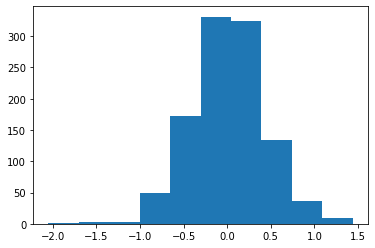

In [23]:
plt.hist(inv_data["Change %"] ,   bins = 10)

### Split 1

In [24]:
percs = np.percentile(train["Change %"],  np.arange(5, 100,5) ); percs

array([-0.66 , -0.5  , -0.405, -0.32 , -0.26 , -0.2  , -0.14 , -0.1  ,
       -0.04 ,  0.01 ,  0.065,  0.11 ,  0.16 ,  0.21 ,  0.27 ,  0.34 ,
        0.415,  0.55 ,  0.71 ])

In [25]:
binpreds = percs[ np.arange(0, 19, 2) ]
binlimits = percs[ np.arange(1, 19, 2) ]

In [ ]:
inv_data["Bin"] = 1

for i in range(0,9):
  idx = inv_data["Change %"] > binlimits[i]
  inv_data["Bin"][idx] = i+2

inv_data["BinPrediction"] = 0

for i in range(0,10):
  idx = inv_data["Bin"] == i+1
  inv_data["BinPrediction"][idx] = binpreds[i]

In [27]:
inv_data["BinPrediction"].value_counts()

 0.065    114
-0.405    111
 0.415    111
-0.660    109
-0.040    107
-0.140    105
 0.270    103
 0.710    102
 0.160    102
-0.260    101
Name: BinPrediction, dtype: int64

### Split 2

In [28]:
width = (3/4)*np.std(inv_data["Change %"]); width

0.31790047649190306

In [29]:
binlimits2 = width * np.arange(-4,5); binlimits2

array([-1.27160191, -0.95370143, -0.63580095, -0.31790048,  0.        ,
        0.31790048,  0.63580095,  0.95370143,  1.27160191])

In [ ]:
inv_data["Bin2"] = 1

for i in range(0,9):
  idx = inv_data["Change %"] > binlimits2[i]
  inv_data["Bin2"][idx] = i+2

inv_data["BinPrediction2"] = 0

for i in range(0,10):
  idx = inv_data["Bin2"] == i+1
  inv_data["BinPrediction2"][idx] = np.median(inv_data["Change %"][idx])

In [31]:
inv_data["BinPrediction2"].value_counts()

 0.140    308
-0.140    303
 0.430    156
-0.430    156
 0.720     57
-0.710     54
 1.055     16
-1.660      5
 1.360      5
-1.010      5
Name: BinPrediction2, dtype: int64

In [32]:
inv_data.iloc[1:,5]

Date
2017-01-03   -0.430
2017-01-04    0.720
2017-01-05    1.055
2017-01-06   -0.710
2017-01-09    0.430
              ...  
2021-01-25   -0.140
2021-01-26    0.140
2021-01-27   -0.430
2021-01-28    0.140
2021-01-29    0.140
Freq: B, Name: BinPrediction2, Length: 1064, dtype: float64

### Plotting Values

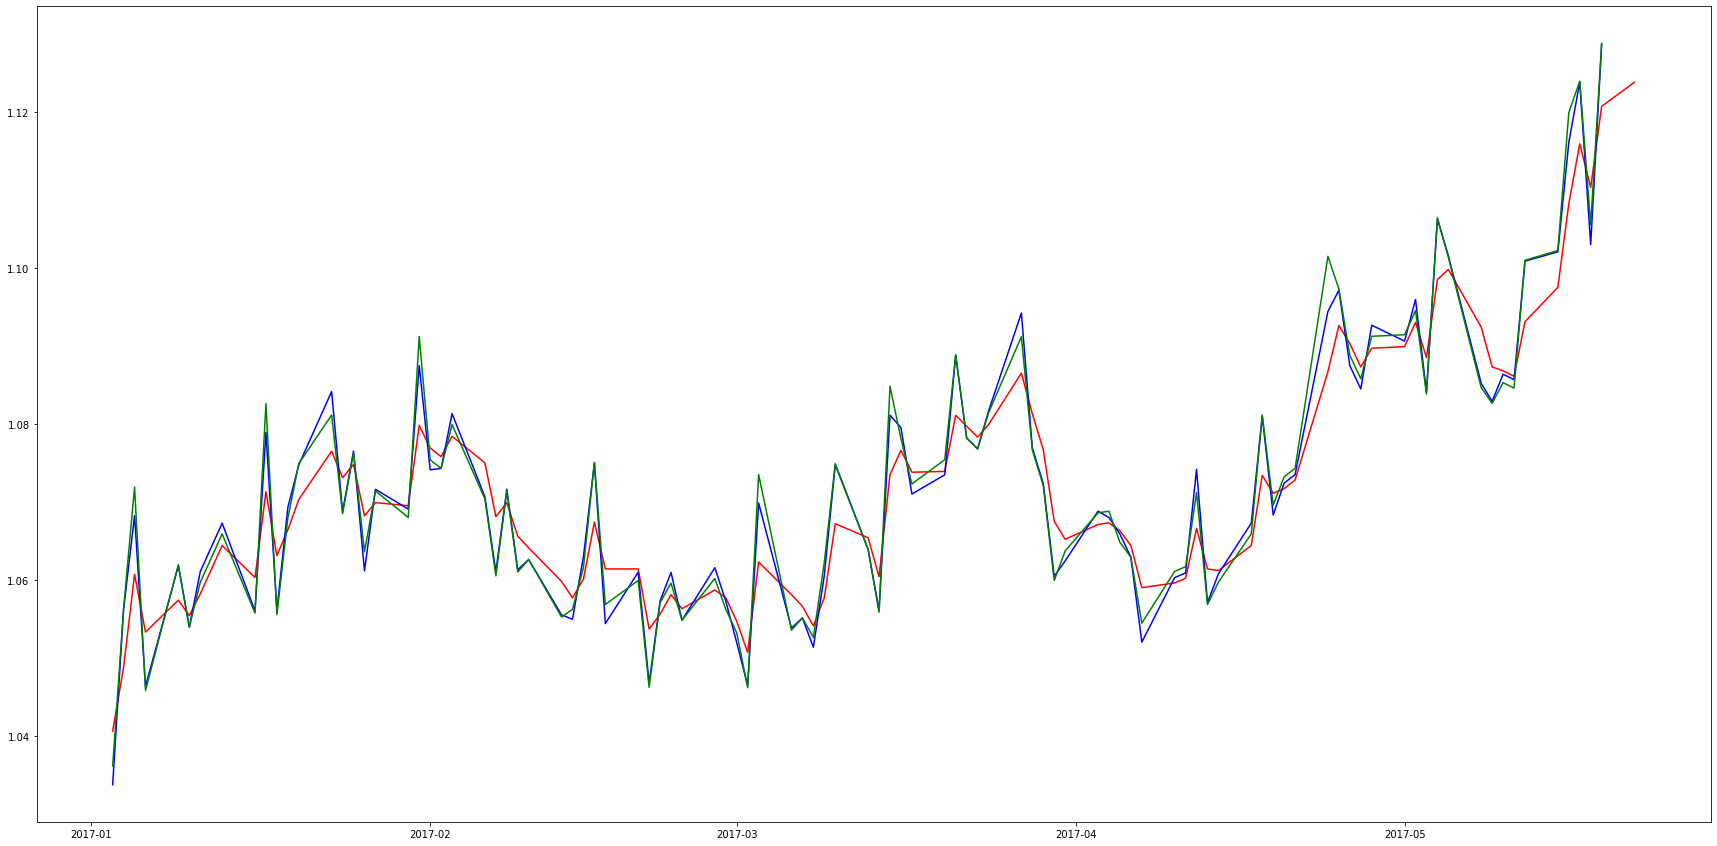

In [33]:
x = np.arange(100)
plt.figure(figsize=(30, 15))
plt.plot(inv_data.iloc[1:101,0], c='red')
classpreds1 = inv_data.iloc[0:100,0] * (1+inv_data.iloc[1:101,3]*0.01 )
classpreds2 = inv_data.iloc[0:100,0] * (1+inv_data.iloc[1:101,5]*0.01 )
plt.plot(classpreds1, c='blue')
plt.plot(classpreds2, c='green')

# ACF - PACF

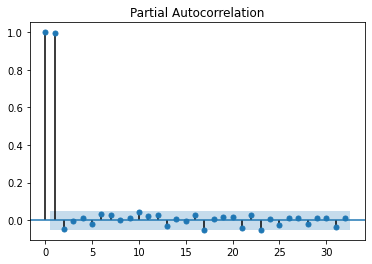

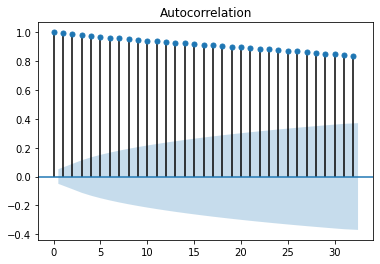

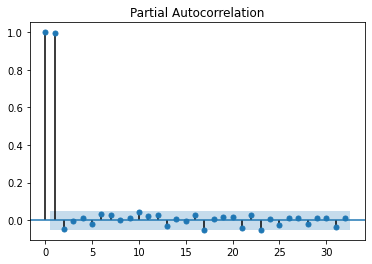

In [ ]:
plot_acf(invts.iloc[:,0]);
plot_pacf(invts.iloc[:,0])

# AR Model

In [ ]:
modelAR = AutoReg(train, lags=14)
modelAR_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

Coefficients: intercept     0.005217
EURUSD.L1     1.013952
EURUSD.L2     0.006860
EURUSD.L3    -0.027439
EURUSD.L4    -0.036004
EURUSD.L5     0.046911
EURUSD.L6    -0.050076
EURUSD.L7     0.027207
EURUSD.L8     0.004948
EURUSD.L9     0.003125
EURUSD.L10   -0.034624
EURUSD.L11    0.046182
EURUSD.L12    0.038210
EURUSD.L13   -0.081066
EURUSD.L14    0.037307
dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


In [ ]:
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [ ]:
rmse = sqrt(mean_squared_error(test, predictions))
mape = abs(predictions/test["EURUSD"] - 1).mean()
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)

Test RMSE: 0.013
Test MAPE: 0.010


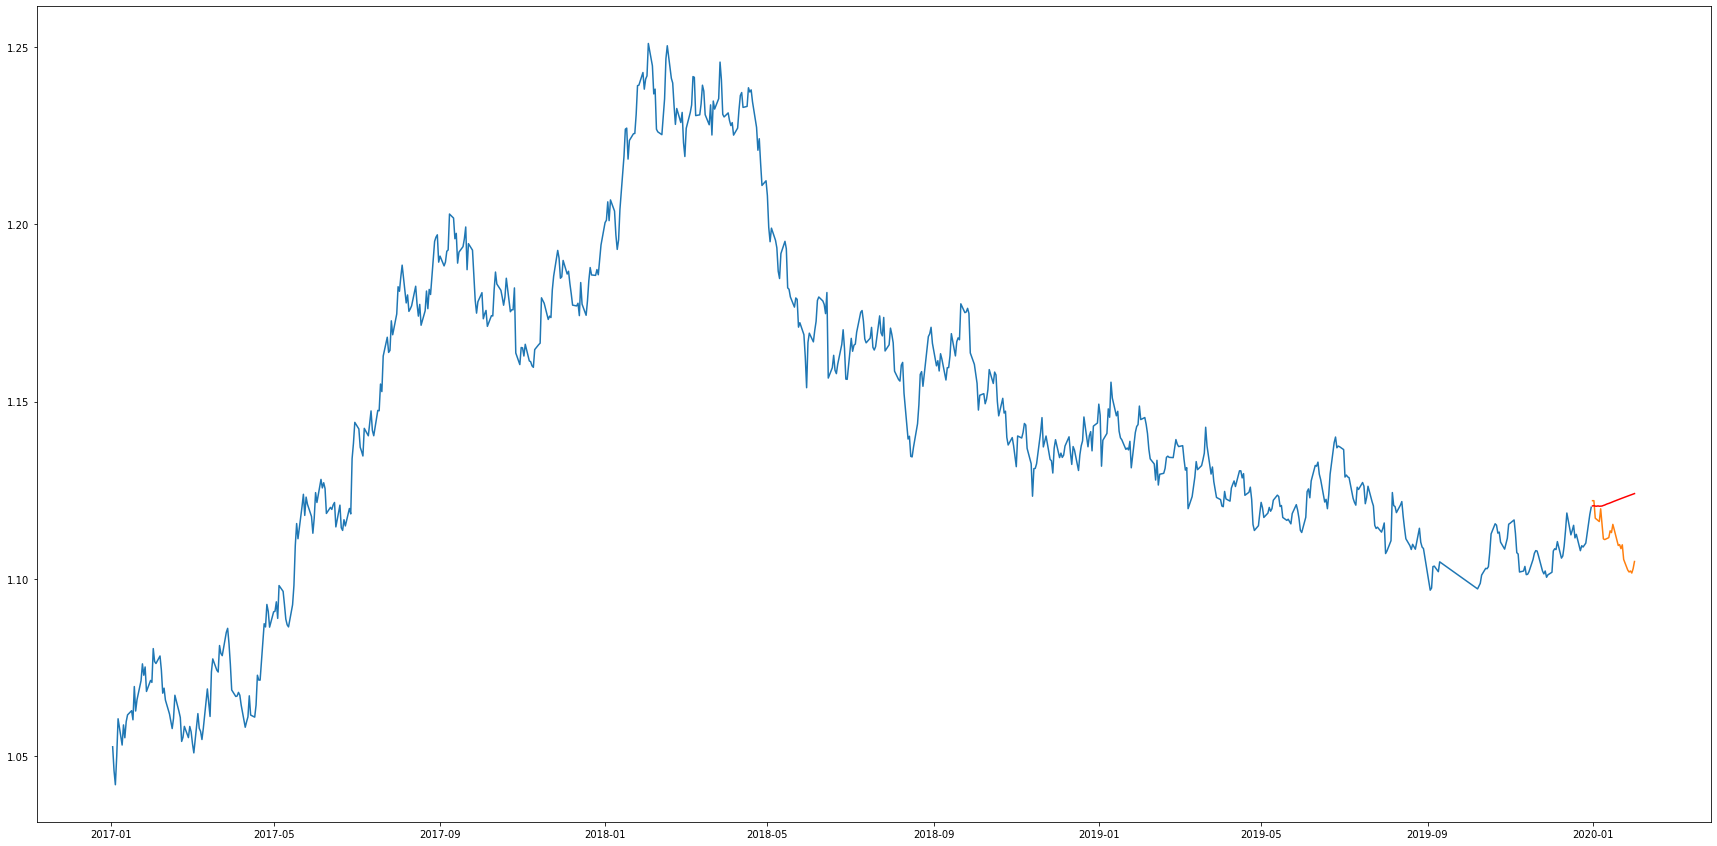

In [ ]:
plt.figure(figsize=(30, 15))
# plt.plot(train.iloc[-75:])
plt.plot(train)
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# AutoARIMA

In [ ]:
model = pm.auto_arima(train)

In [ ]:
forecasts = model.predict(test.shape[0])  # predict N steps into the future
predictions = pd.Series(forecasts, index=test.index)

In [ ]:
rmse = sqrt(mean_squared_error(test, predictions))
mape = abs(predictions/test["EURUSD"] - 1).mean()
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)

Test RMSE: 0.011
Test MAPE: 0.009


In [ ]:
model

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

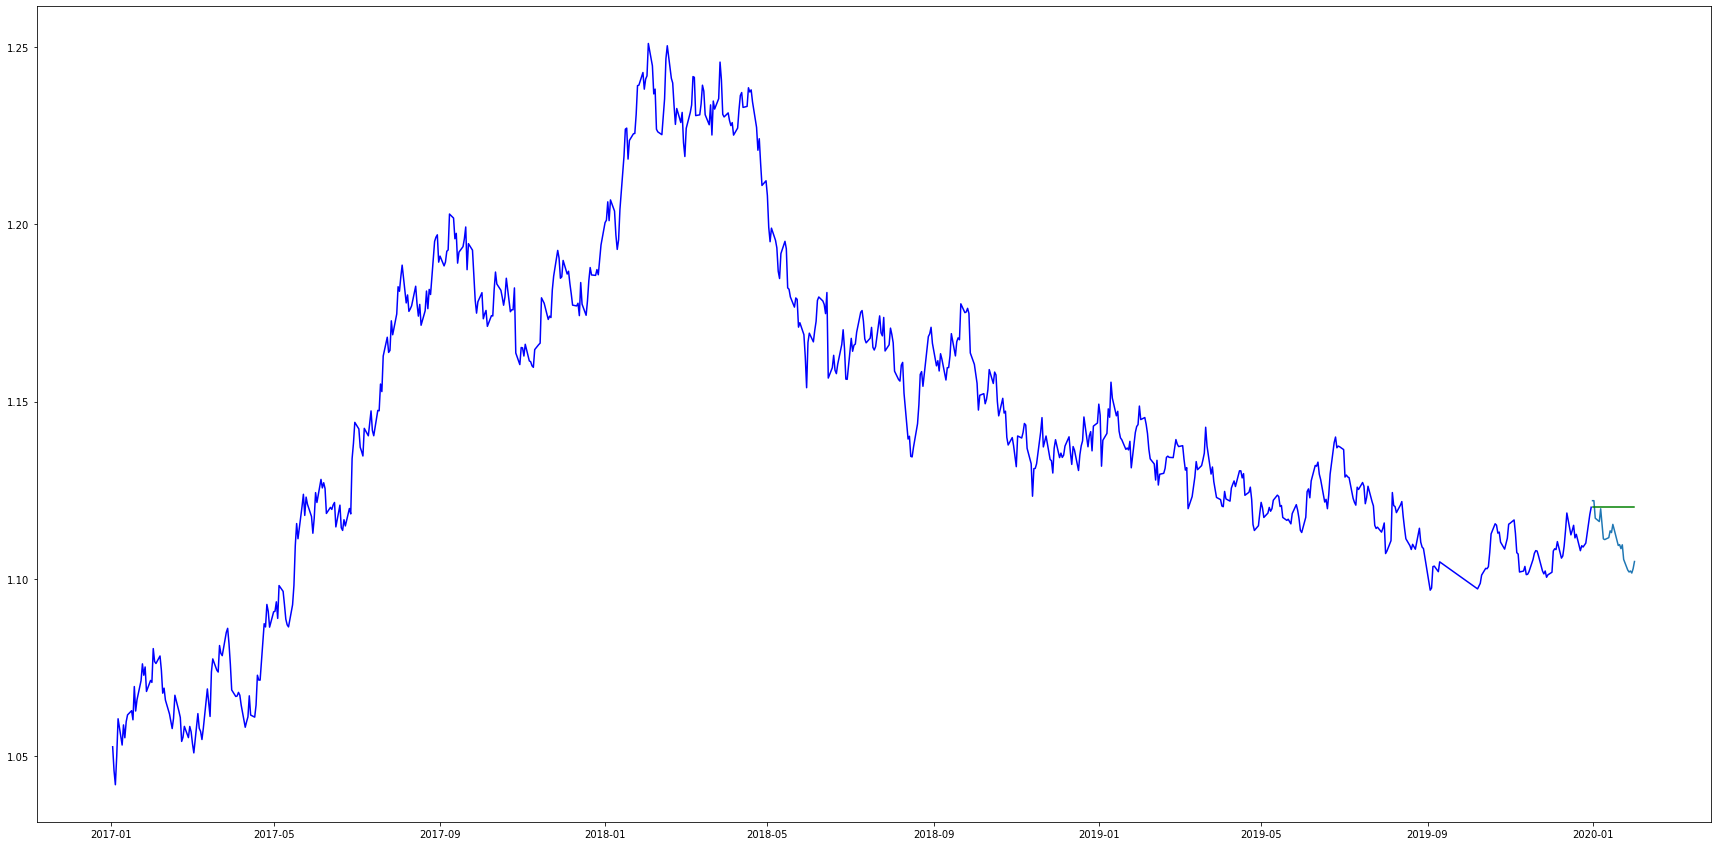

In [ ]:
# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(train.shape[0] + test.shape[0])
plt.figure(figsize=(30, 15))
plt.plot(train, c='blue')
plt.plot(test)
plt.plot(predictions, c='green')
plt.show()

# AR-Net from Scratch

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import backend as K
from keras import initializers
from keras import activations

## Hyperparameters

In [ ]:
lr = 0.01
batch_size = 256
epochs = 100
lag = 7
step = 0

## Preparing AR-Net Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# scaler = MinMaxScaler()
# invts["normEURUSD"] = scaler.fit_transform(invts["EURUSD"][:,None])
# inverse = scaler.inverse_transform(invts)

In [ ]:
invts.head()

,EURUSD,Change %
Date,,
2017-01-02,1.0459,-0.54
2017-01-03,1.0406,-0.51
2017-01-04,1.0488,0.79
2017-01-05,1.0607,1.13
2017-01-06,1.0533,-0.70


In [ ]:
def CreateKLagDF(df, colname, lag = 3, step = 0):
  resdf = df.copy()
  for i in range(1,lag+1):
    label = "lag" + str(i)
    a = np.array(i*[None])
    b = np.array(resdf[colname][:-i])
    
    newcol = np.concatenate([a, b], axis= 0)
    resdf[label] = newcol.astype(np.float64)

  for i in range(1,step+1):
    label = "step" + str(i)
    a = np.array(resdf[colname][i:])
    b = np.array(i*[None])

    newcol = np.concatenate([a, b], axis= 0)
    resdf[label] = newcol.astype(np.float64)
    
  return resdf


In [ ]:
arnetinv = CreateKLagDF(invts,"EURUSD", lag = lag, step = step);arnetinv.dtypes

EURUSD      float64
Change %    float32
lag1        float64
lag2        float64
lag3        float64
lag4        float64
lag5        float64
lag6        float64
lag7        float64
dtype: object

In [ ]:
arnetinv = arnetinv.iloc[lag:,:] ; arnetinv.head()

,EURUSD,Change %,lag1,lag2,lag3,lag4,lag5,lag6,lag7
Date,,,,,,,,,
2017-01-09,1.0574,0.39,1.056033,1.054667,1.053300,1.060700,1.048800,1.040600,1.0459
2017-01-10,1.0554,-0.19,1.057400,1.056033,1.054667,1.053300,1.060700,1.048800,1.0406
2017-01-11,1.0582,0.27,1.055400,1.057400,1.056033,1.054667,1.053300,1.060700,1.0488
2017-01-12,1.0613,0.29,1.058200,1.055400,1.057400,1.056033,1.054667,1.053300,1.0607
2017-01-13,1.0644,0.29,1.061300,1.058200,1.055400,1.057400,1.056033,1.054667,1.0533


In [ ]:
arnetinv.dtypes

EURUSD      float64
Change %    float32
lag1        float64
lag2        float64
lag3        float64
lag4        float64
lag5        float64
lag6        float64
lag7        float64
dtype: object

In [ ]:
trainidx = range(0,len(arnetinv) -14)
valididx = range(len(arnetinv) - 14, len(arnetinv) - 7 )
testidx = range(len(arnetinv) -7 , len(arnetinv) )

arnettrain = arnetinv.iloc[trainidx]
arnetvalid = arnetinv.iloc[valididx]
arnettest = arnetinv.iloc[testidx]

In [ ]:
xtrain = tf.constant(arnettrain.iloc[:,2:].astype('float64')) 
ytrain = tf.constant(arnettrain.iloc[:,0:1].astype('float64'))

xvalid = tf.constant(arnetvalid.iloc[:,2:].astype('float64')) 
yvalid = tf.constant(arnetvalid.iloc[:,0:1].astype('float64'))

In [ ]:
ytrain.dtype

tf.float64

## AR-Net Model

In [ ]:
del mArnet

In [ ]:
np.random.seed(46)

mArnet = Sequential()
mArnet.add(BatchNormalization())
mArnet.add(Dense(150, kernel_initializer = initializers.GlorotUniform(), bias_initializer=initializers.Zeros(), input_dim=lag))
mArnet.add(Activation(activations.relu))
mArnet.add(BatchNormalization())
mArnet.add(Dense(250, kernel_initializer = initializers.GlorotUniform() , bias_initializer=initializers.Zeros()))
mArnet.add(Activation(activations.relu))
mArnet.add(BatchNormalization())
mArnet.add(Dense(300, kernel_initializer = initializers.GlorotUniform() , bias_initializer=initializers.Zeros()))
mArnet.add(Activation(activations.relu))
mArnet.add(BatchNormalization())
mArnet.add(Dense(1,activation= "linear", kernel_initializer=initializers.GlorotUniform(), bias_initializer=initializers.Zeros()))

In [ ]:
mArnet.compile(loss=keras.losses.mean_squared_error ,
              optimizer=keras.optimizers.Adam( learning_rate= lr),
              metrics=['mse'])

In [ ]:
history = mArnet.fit(xtrain, ytrain,
                           batch_size=batch_size, 
                           epochs=epochs,
                           verbose=0, shuffle = False,
                           validation_data=(xvalid, yvalid ))

In [ ]:
mArnet.weights

In [ ]:
preds1 = mArnet.predict(xtrain)
preds2 = mArnet.predict(xvalid );preds2

array([[1.1781085],
       [1.1620362],
       [1.1601012],
       [1.1577543],
       [1.1668385],
       [1.162826 ],
       [1.1698939]], dtype=float32)

In [ ]:
# preds1 = scaler.inverse_transform(preds1)
# preds2 = scaler.inverse_transform(preds2)

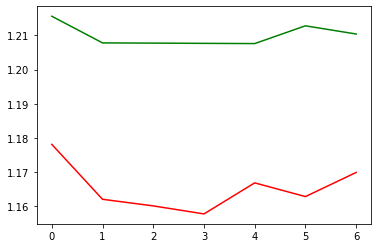

In [ ]:
plt.plot(xvalid[:,1], c = 'green')
plt.plot(preds2, c='red')

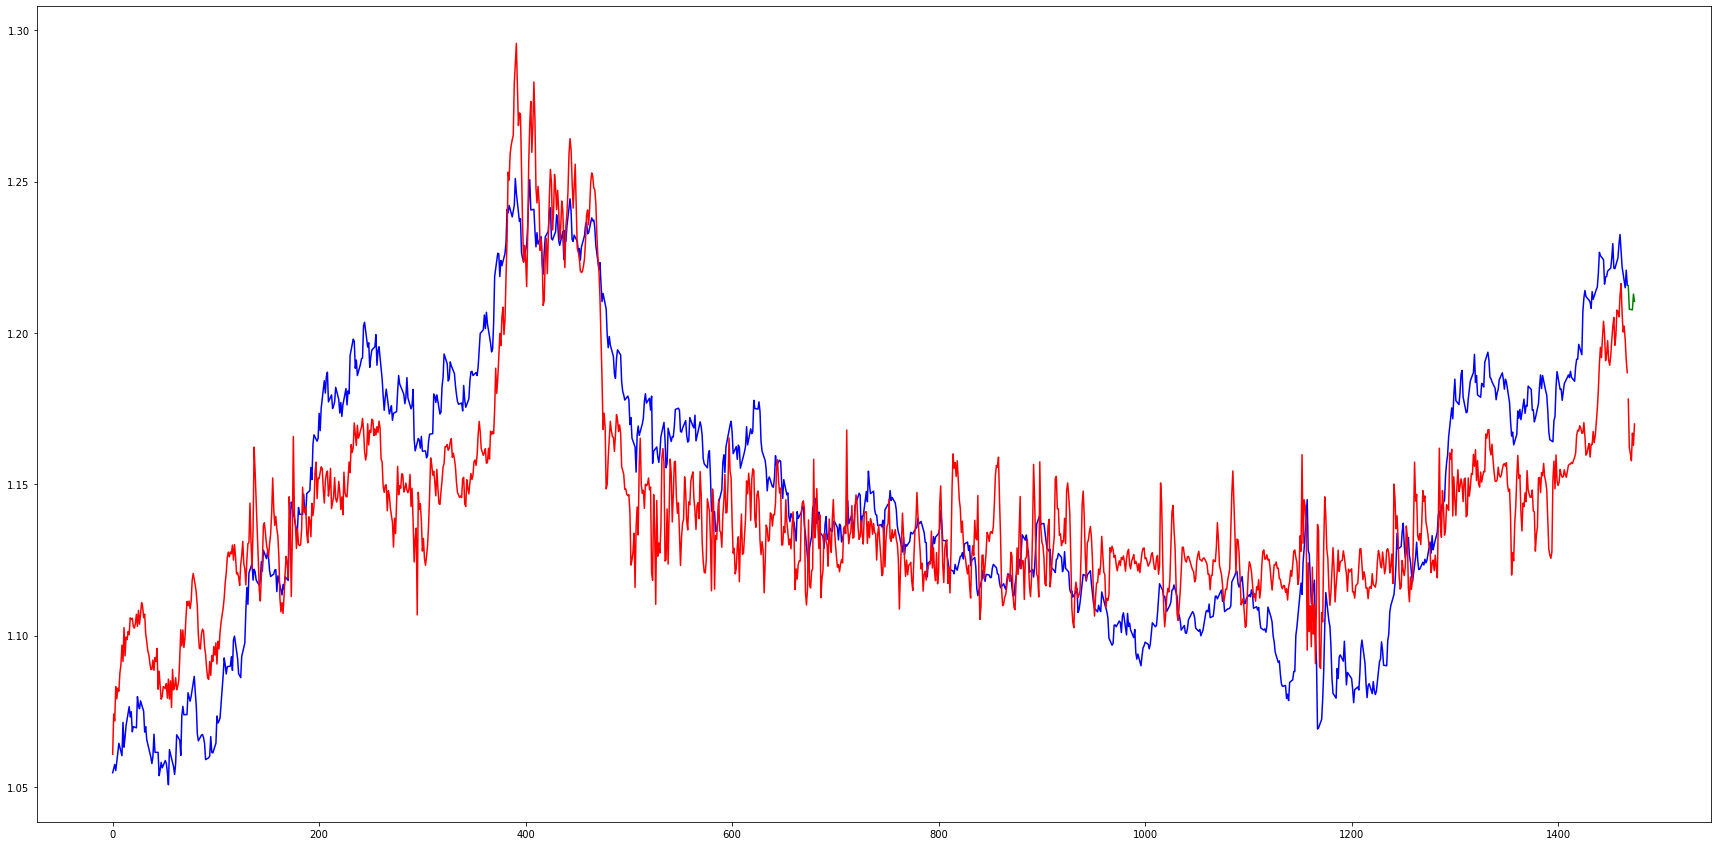

In [ ]:
x = np.arange(xtrain.shape[0], xtrain.shape[0] + xvalid.shape[0])
plt.figure(figsize=(30, 15))
plt.plot(xtrain[:,1], c='blue')
plt.plot(preds1, c='red')
plt.plot(x ,xvalid[:,1], c = 'green')
plt.plot(x ,preds2, c='red')
plt.show()

# Amazon Sagemaker

In [34]:
if 'google.colab' in str(get_ipython()):
  !pip install sagemaker